In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.feature_selection import SelectorMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectorMixin, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report

In [2]:
# Load the development set
with open('../data/development_set.pkl', 'rb') as f:
    X_dev_set, y_dev_set = pickle.load(f)
# Load the test set
with open('../data/test_set.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)
# Software metrics_concidered
with open('../data/metrics_concidered.pkl', 'rb') as file:
    metrics_concidered = pickle.load(file)

In [3]:
# Load best model
with open('../model/best_model.pkl', 'rb') as f:
    model = pickle.load(f)

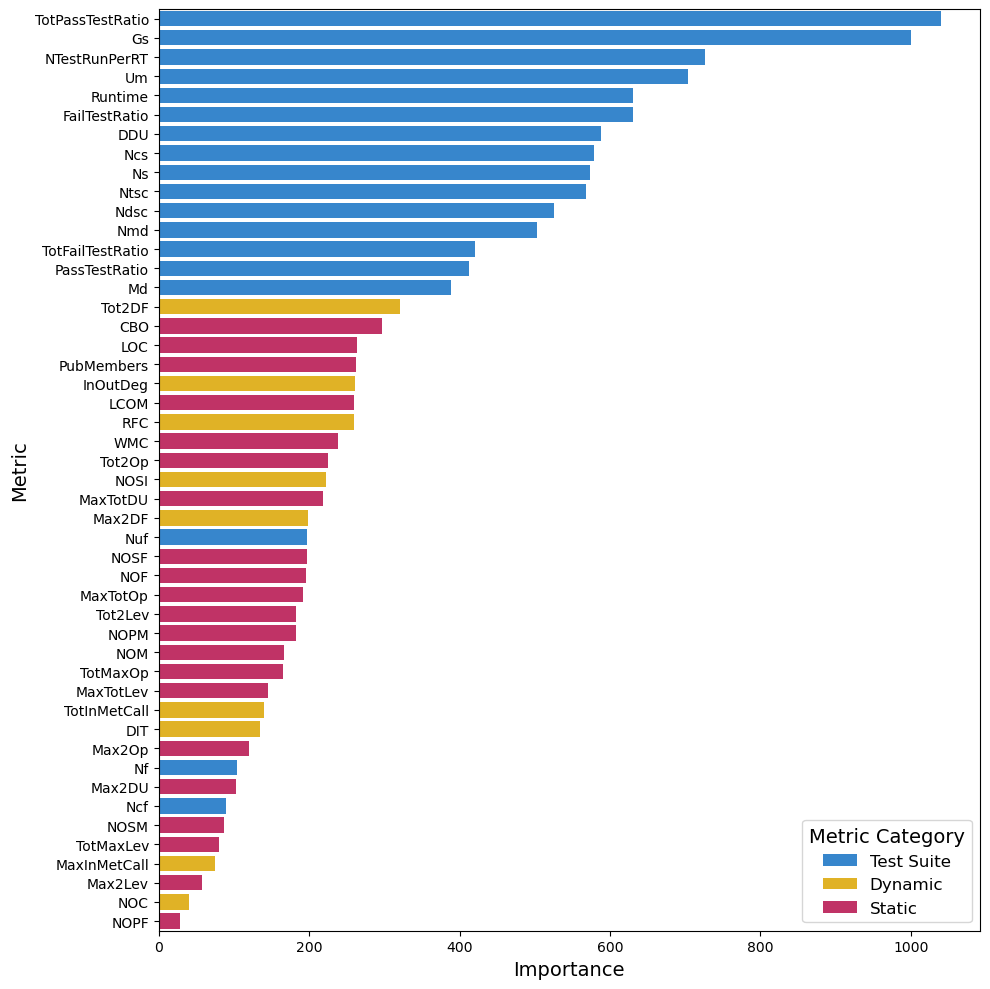

In [4]:
feature_type_mapping = {
    'CBO': 'Static', 'NOF': 'Static', 'NOPF': 'Static', 'NOSF': 'Static', 'NOM': 'Static',
    'NOPM': 'Static', 'NOSM': 'Static', 'WMC': 'Static', 'McCabe\'s complexity': 'Static', 'LOC': 'Static',
    'LCOM': 'Static', 'Tot2Op': 'Static', 'TotMaxOp': 'Static', 'Max2Op': 'Static', 'MaxTotOp': 'Static',
    'Tot2Lev': 'Static', 'TotMaxLev': 'Static', 'MaxTotLev': 'Static', 'Max2Lev': 'Static', 'Tot2DU': 'Static',
    'TotMaxDU': 'Static', 'PubMembers': 'Static', 'Max2DU': 'Static', 'MaxTotDU': 'Static', 

    'DIT': 'Dynamic', 'NOSI': 'Dynamic', 'NOC': 'Dynamic', 'RFC': 'Dynamic', 'Tot2DF': 'Dynamic',
    'TotMaxDF': 'Dynamic', 'Max2DF': 'Dynamic', 'MaxTotDF': 'Dynamic', 'TotInMetCall': 'Dynamic', 
    'MaxInMetCall': 'Dynamic', 'InOutDeg': 'Dynamic',

    'Runtime': 'Test Suite', 'Ncf': 'Test Suite', 'Nuf': 'Test Suite', 'Ncs': 'Test Suite', 'Ns': 'Test Suite', 
    'Nf': 'Test Suite', 'Ntsc': 'Test Suite', 'Ndsc': 'Test Suite', 'Nntc': 'Test Suite', 'Jaccard': 'Test Suite', 
    'PassTestRatio': 'Test Suite', 'FailTestRatio': 'Test Suite', 'TotPassTestRatio': 'Test Suite', 
    'TotFailTestRatio': 'Test Suite', 'NTestRunPerRT': 'Test Suite', 'Um': 'Test Suite', 'Md': 'Test Suite', 
    'Nmd': 'Test Suite', 'Gs': 'Test Suite', 'DDU': 'Test Suite',

    'N_Files': 'Bug Characteristics', 'N_Classes': 'Bug Characteristics', 'N_Methods': 'Bug Characteristics', 
    'N_Lines': 'Bug Characteristics', 'N_Added': 'Bug Characteristics', 'N_Removed': 'Bug Characteristics', 
    'N_Modified': 'Bug Characteristics', 'N_Chunks': 'Bug Characteristics', 'N_RepairActions': 'Bug Characteristics', 
    'N_RepairPatterns': 'Bug Characteristics', 'FirstException': 'Bug Characteristics', 'Loc_Predicat': 'Bug Characteristics', 
    'Loc_ConditionalBlock': 'Bug Characteristics', 'Loc_FunctionBody': 'Bug Characteristics', 
    'Loc_Constructor': 'Bug Characteristics', 'Loc_LoopBody': 'Bug Characteristics'
}

# Colorblind-friendly palette
colorblind_palette = {
    'Static': '#D81B60',
    'Dynamic': '#FFC107',
    'Test Suite': '#1E88E5'
}



best_model_importance = pd.DataFrame({
        "Feature": metrics_concidered,
        "Importance": model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

best_model_importance['Type'] = best_model_importance['Feature'].map(feature_type_mapping)

# Plot 
def plot_feature_importance(importance_df):
    plt.figure(figsize=(10, 10))
    sorted_importance = importance_df.sort_values(by="Importance", ascending=False).head(50)
    
    sns.barplot(
        x="Importance", y="Feature", data=sorted_importance,
        hue="Type", dodge=False, palette=colorblind_palette  # Color by feature type
    )
    
    plt.xlabel("Importance", fontsize=14)
    plt.ylabel("Metric", fontsize=14)
    plt.legend(title='Metric Category', fontsize=12, title_fontsize=14, loc='lower right')
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_model_importance)

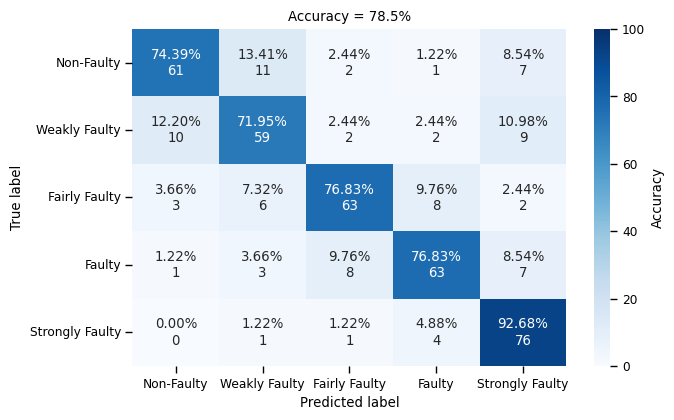

In [5]:
# Label mapping
label_to_int = {
    'Non-Faulty': 0,
    'Weakly Faulty': 1,
    'Fairly Faulty': 2,
    'Faulty': 3,
    'Strongly Faulty': 4
}

def draw_confusion_matrix(ground_truth, predicted):
    # Compute confusion matrix
    matrix = confusion_matrix(ground_truth, predicted)
    percentages = (matrix.T / matrix.sum(axis=1)).T
    # Set cell format
    flattened_counts = [value for value in matrix.flatten()]
    flattened_percentages = ["{0:.2%}".format(value) for value in percentages.flatten()]
    labels = [f"{percentage}\n{value}" for value, percentage in zip(flattened_counts, flattened_percentages)]
    labels = np.asarray(labels).reshape(matrix.shape[0], matrix.shape[1])
    # Formatting
    percentDataframe = pd.DataFrame(percentages * 100, 
                                    columns=[key for key in label_to_int.keys()],
                                    index=[key for key in label_to_int.keys()])
    
    # Plot
    sns.set_context('paper', font_scale=1.0)
    width = 7
    height = width / 1.6
    plt.figure(figsize=(width, height))
    ax = plt.axes()
    # Heatmap of the confusion matrix
    sns.heatmap(percentDataframe, annot=labels, fmt='', cmap='Blues', ax=ax, vmin=0, vmax=100, cbar_kws={'label': 'Accuracy'})
    ax.yaxis.set_tick_params(rotation=0)
    ax.set(xlabel='Predicted label', ylabel='True label')
    ax.title.set_text('Accuracy = {0:.1%}'.format(sum(1 for x, y in zip(ground_truth, predicted) if x == y) / len(ground_truth)))
    plt.show()

y_pred = model.predict(X_test)
draw_confusion_matrix(y_test, y_pred) 